# Notebook for perceptual salience of positive-Self

## Stimulus-coding HDDM for Matching task

This is the script for the drift diffusion model analysis used in Hu, et al., 2019, Notebook for perceptual salience of positive-Self (https://osf.io/83dyj/).


This script decompose the RT and accuracy data into 4 parameters of DDM. The mean of each individual's parameter were then used for analysis of indivdual differences.

The HDDM used here is a docker image run in Ubuntu 20.04. Hardware is the 64-bit machine.

[Install docker](https://docs.docker.com/get-docker/).

Pull the HDDM docker image from the internet ( ~ 5.6 GB)

`docker pull madslupe/hddm`

Run docker (with sudo permission)
`docker run -it --rm \
-v /you_folder_of_data:/home/jovyan/hddm \
-p 8888:8888 madslupe/hddm jupyter notebook`

You will see an url appear in the terminal, right click and open that link, you shall see two folders in the jupyter notebook: `work`, `hddm`. The `hddm` is the folder linked to the folder you stored your data. 

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
#import sys
#print('The current Python version is', sys.version)

# or uncomment the code below

from platform import python_version

print('The current HDDM version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython
print('The current HDDM version is', hddm.__version__) # 0.8.0

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

Notebook is running: /home/hcp4715/miniconda3/envs/py_ddm/bin/python
The current HDDM version is 3.7.7
The current HDDM version is 0.8.0
The current IPython version is 7.13.0



Bad key "text.kerning_factor" on line 4 in
/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import datetime

# import the toolbox
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

import random

# set the color of plots
#from cycler import cycler
#plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

## Simulate data and parameter recovery

Given that we are interested in the drift rate $v$, let see how which model recovers the drift rate $v$ best.


### First Generate random day with certain drift rate


/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


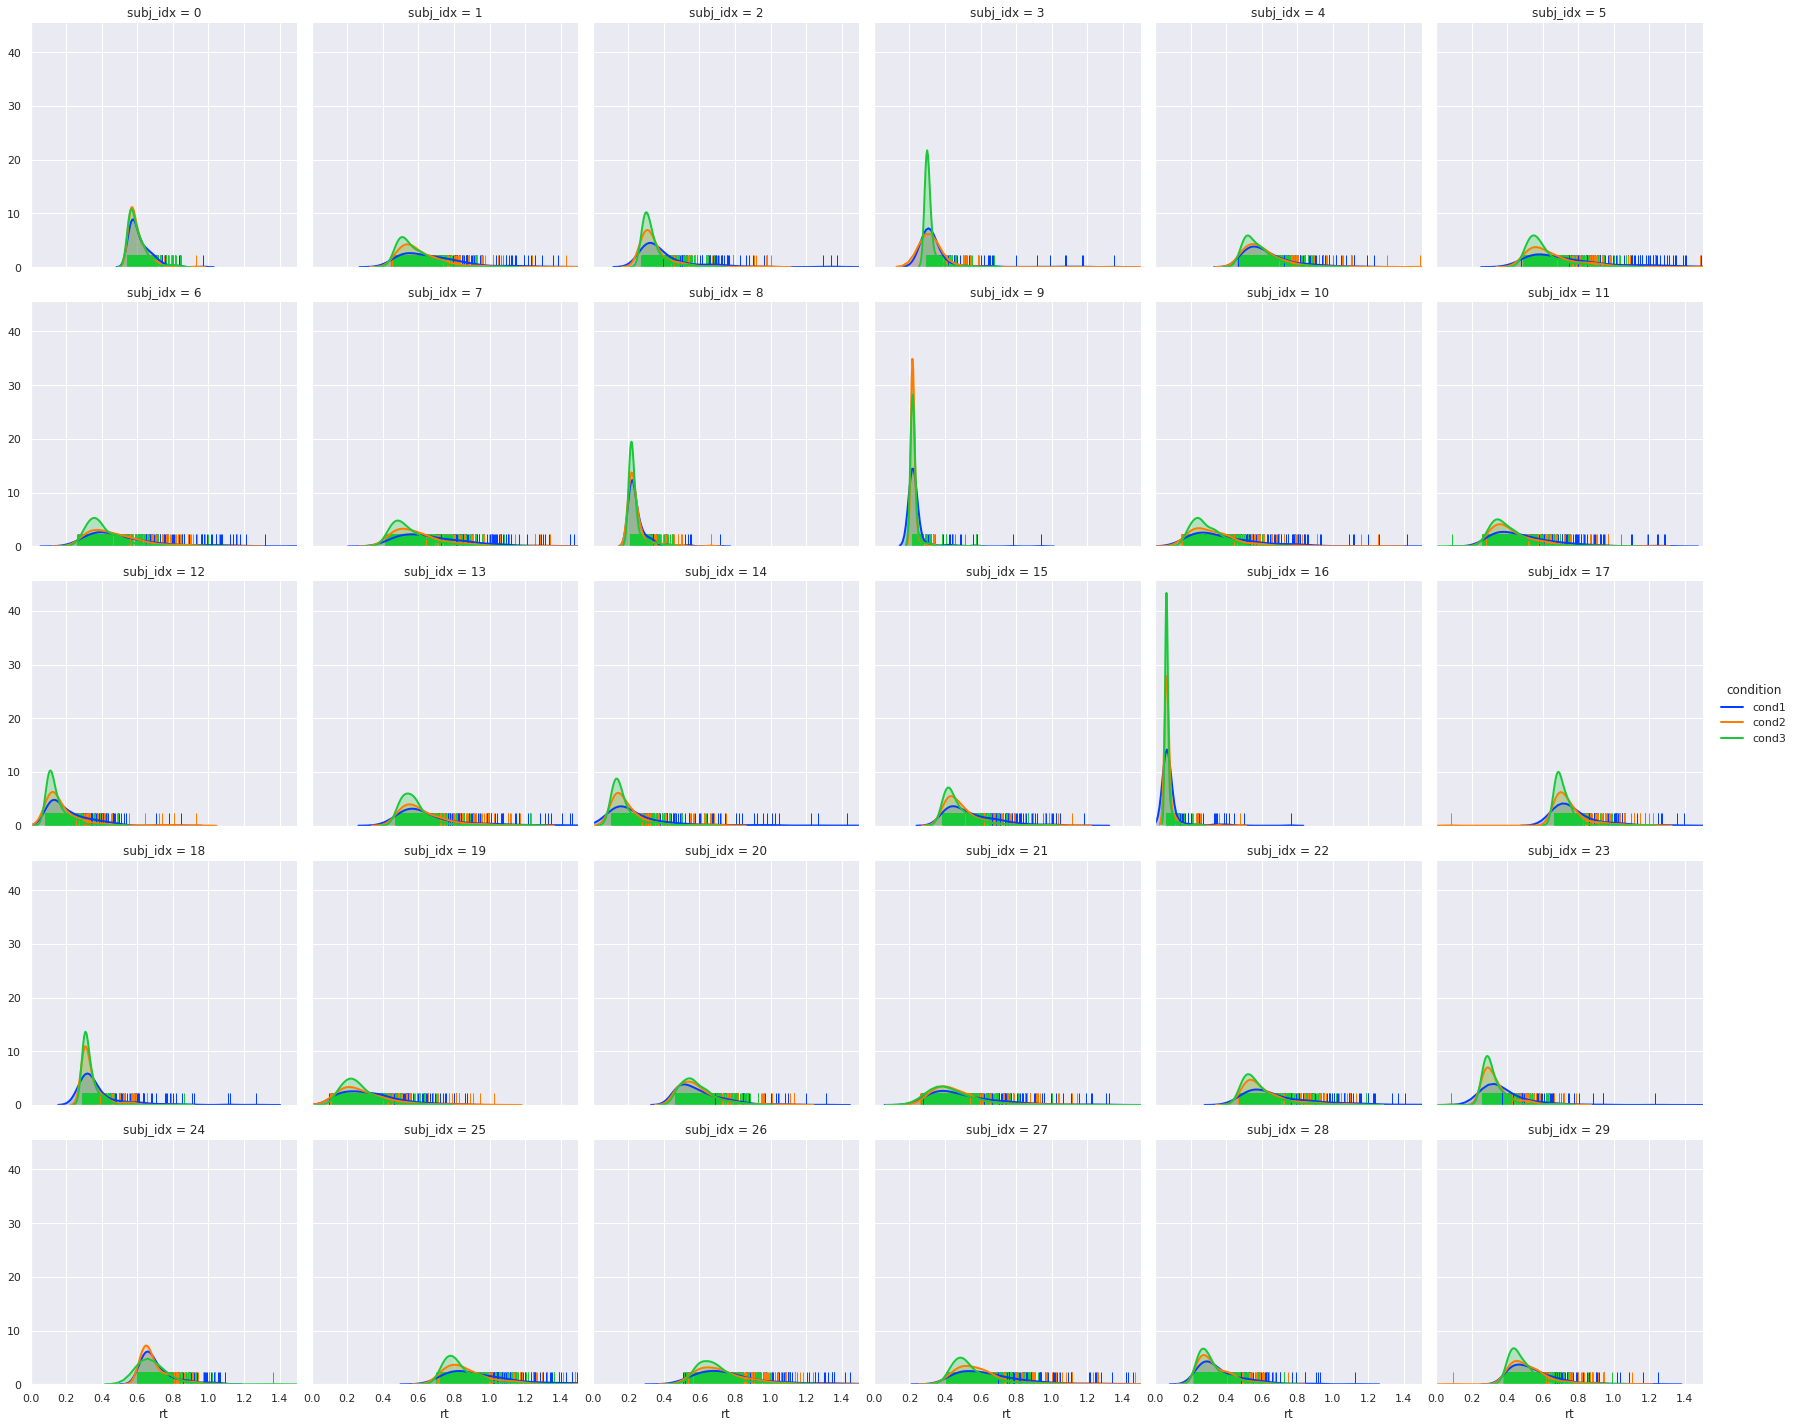

In [3]:
# Generate random data, assuming that only drift rate is different. 
# for more details about hddm.generate.gen_rand(), uncomment below:
# ?hddm.generate.gen_rand
# import kabuki
# ?kabuki.generate.gen_rand_data

df_gen, prms_gen = hddm.generate.gen_rand_data({'cond1': {'v':1.5, 'a':1, 't':.4, 'z': 0.55},
                                                'cond2': {'v':2.5, 'a':1, 't':.4, 'z': 0.55},
                                                'cond3': {'v':3.5, 'a':1, 't':.4, 'z': 0.55}}, 
                                               n_fast_outliers= 5, 
                                               n_slow_outliers=5,
                                               subj_noise=0.2, # how much to pertub individual subj params, default = 0.1
                                               size = 300,
                                               subjs = 30)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

g = sns.FacetGrid(df_gen, col='subj_idx', col_wrap=6, hue="condition", height=4, palette="bright")
g = (g.map(sns.distplot, "rt", hist = False, kde = True,
           kde_kws = {'shade': True, 'linewidth': 2}, rug=True)
     .set(xlim=(0, 1.5))  # , ylim=(0, 12))
     .add_legend())

In [7]:
prms_gen

{'cond1': [{'v': 1.646064475732651,
   'a': 0.5783976065630418,
   't': 0.5348858997130707,
   'z': 0.5239525561662411},
  {'v': 1.6404758578329537,
   'a': 1.092721192907047,
   't': 0.4203222547391645,
   'z': 0.4696909503030205},
  {'v': 1.5312289614085168,
   'a': 1.0618611449425397,
   't': 0.26844109343563605,
   'z': 0.7710258761021818},
  {'v': 1.2477946084500144,
   'a': 1.0896301541137245,
   't': 0.29152186237968025,
   'z': 0.924490859378073},
  {'v': 1.2663501224986886,
   'a': 0.9169507967762247,
   't': 0.4510984030289243,
   'z': 0.484649754227874},
  {'v': 1.3809188870636424,
   'a': 1.2339974187960123,
   't': 0.47070284736330636,
   'z': 0.6458257177085838},
  {'v': 1.4971167167926605,
   'a': 1.1107908220815894,
   't': 0.23820633845592767,
   'z': 0.37685204361638114},
  {'v': 1.3144940087582768,
   'a': 1.3573885130021837,
   't': 0.38431976981540333,
   'z': 0.5639350743053879},
  {'v': 1.6037634504768126,
   'a': 0.8065737071148602,
   't': 0.20570820712979687,


### Fit the model with the generated data

In [8]:
## Recover model 1, only free parameter v

rcv_m1 = hddm.HDDM(df_gen, depends_on={'v':['condition']},p_outlier=0.05)

rcv_m1.find_starting_values()
rcv_m1.sample(3000, burn=1500, dbname='rcv_m1.db', db='pickle')
rcv_m1.save('rcv_m1')

/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1231.2 sec

Plotting a
Plotting a_std
Plotting v(cond1)
Plotting v(cond2)
Plotting v(cond3)
Plotting t


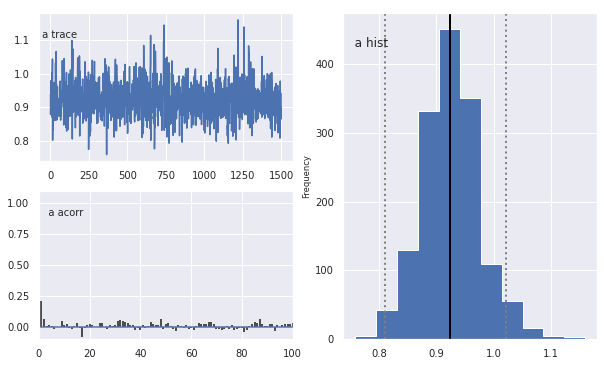

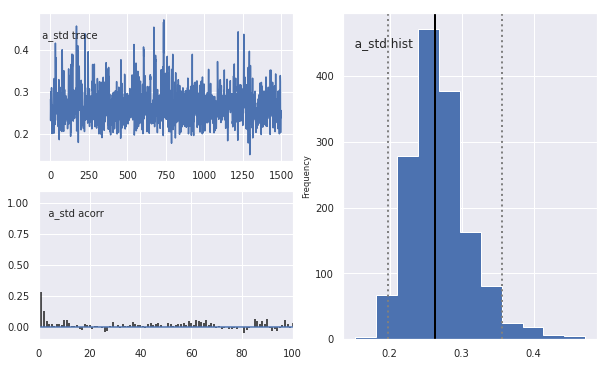

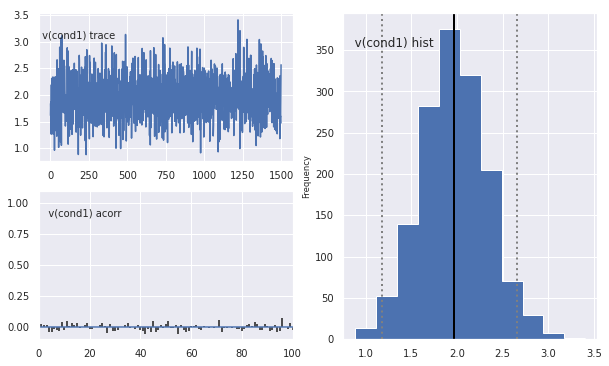

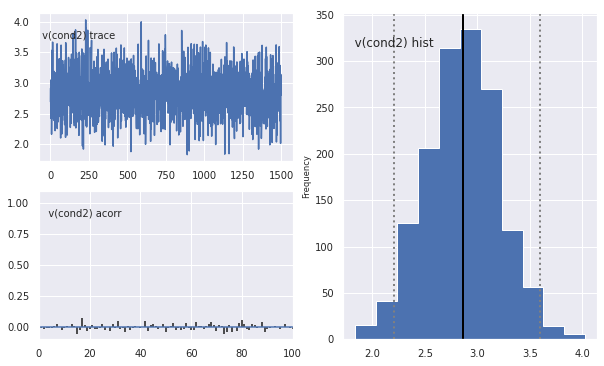

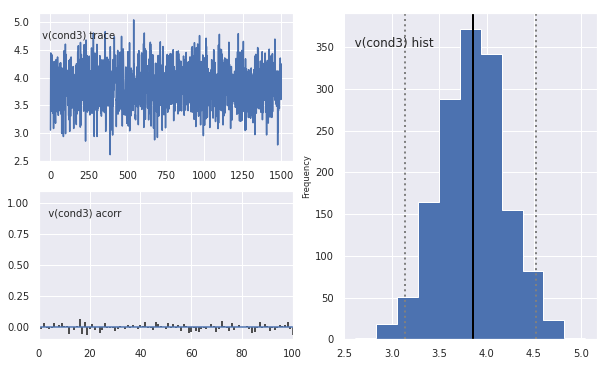

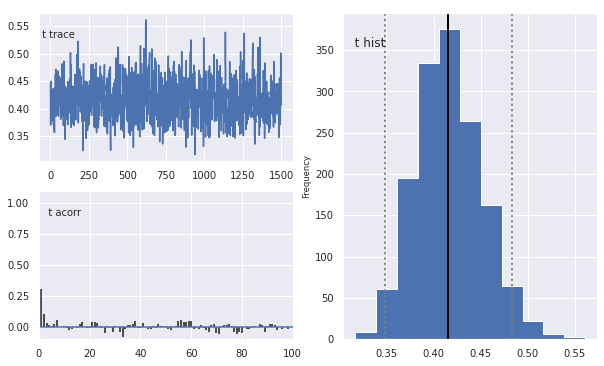

In [9]:
rcv_m1.plot_posteriors(['a', 't', 'v', 'a_std'])

AttributeError: 'Polygon' object has no property 'normed'

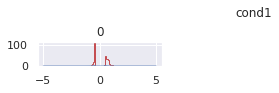

In [14]:
# rcv_m1.plot_posterior_predictive()

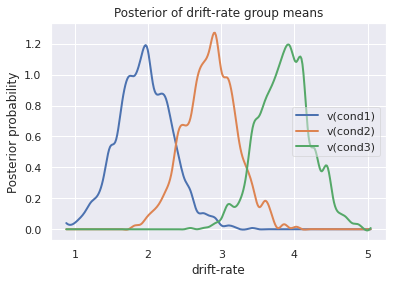

In [16]:
v_cond1, v_cond2, v_cond3 = rcv_m1.nodes_db.node[['v(cond1)', 'v(cond2)', 'v(cond3)']]
hddm.analyze.plot_posterior_nodes([v_cond1, v_cond2, v_cond3])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
#plt.savefig('hddm_demo_fig_06.pdf')

Seems that when use $v$ alone, the estimation will systematically shifted to right.

In [22]:
rcv_m2 = hddm.HDDM(df_gen, depends_on={'v':['condition'], 'a':['condition'], 't':['condition']},
                   p_outlier=0.05)

rcv_m2.find_starting_values()
rcv_m2.sample(3000, burn=1500, dbname='rcv_m2.db', db='pickle')
rcv_m2.save('rcv_m2')

/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3000 of 3000 complete in 1252.4 sec

Text(0.5, 1.0, 'Posterior of drift-rate group means')

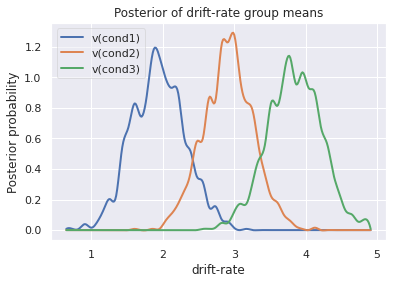

In [23]:
v_cond1, v_cond2, v_cond3 = rcv_m2.nodes_db.node[['v(cond1)', 'v(cond2)', 'v(cond3)']]
hddm.analyze.plot_posterior_nodes([v_cond1, v_cond2, v_cond3])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

So the model with $a$, $t$, $v$ also overestimate, because the v is biased.

In [4]:
rcv_m3 = hddm.HDDM(df_gen, depends_on={'v':['condition'], 'z':['condition']},
                   p_outlier=0.05)

rcv_m3.find_starting_values()
rcv_m3.sample(3000, burn=1500, dbname='rcv_m3.db', db='pickle')
rcv_m3.save('rcv_m3')


/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3000 of 3000 complete in 1234.3 sec

NameError: name 'rcv_m2' is not defined

Text(0.5, 1.0, 'Posterior of drift-rate group means')

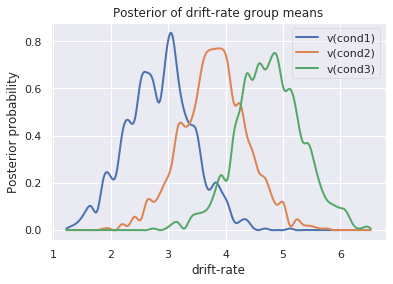

In [5]:
v_cond1, v_cond2, v_cond3 = rcv_m3.nodes_db.node[['v(cond1)', 'v(cond2)', 'v(cond3)']]
hddm.analyze.plot_posterior_nodes([v_cond1, v_cond2, v_cond3])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1244.8 sec

Text(0.5, 1.0, 'Posterior of drift-rate group means')

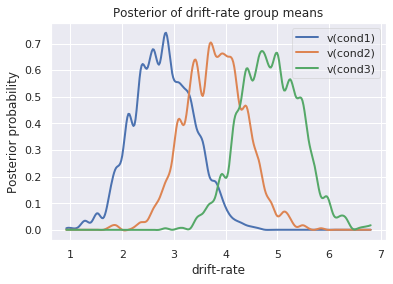

In [6]:
rcv_m4 = hddm.HDDM(df_gen, depends_on={'v':['condition'], 'z':['condition'], 't':['condition']},
                   p_outlier=0.05)

rcv_m4.find_starting_values()
rcv_m4.sample(3000, burn=1500, dbname='rcv_m4.db', db='pickle')
rcv_m4.save('rcv_m4')

v_cond1, v_cond2, v_cond3 = rcv_m4.nodes_db.node[['v(cond1)', 'v(cond2)', 'v(cond3)']]
hddm.analyze.plot_posterior_nodes([v_cond1, v_cond2, v_cond3])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

In [21]:
rcv_m1.nodes_db.node[['v(cond1)', 'v(cond2)', 'v(cond3)']].head(20)

v(cond1)    v(cond1)
v(cond2)    v(cond2)
v(cond3)    v(cond3)
Name: node, dtype: object

### Compare the recovered parameter with the ground truth

plot the $v$ fro three conditions and compare them with the ground truth: 1.5, 2.5, 3.5

## Experiment 1a

Load data

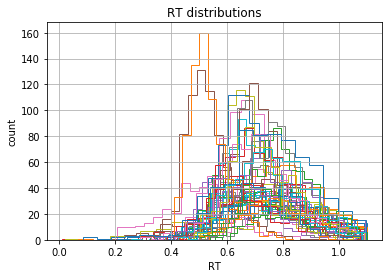

In [3]:
# load data
df1a = hddm.load_csv('df1a.v.hddm_stim.csv')

df1a.head(10)  # uncomment if you want to check the head of the data

# Uncomment the codes below if you are interested in checking the distribution of raw data
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df1a.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_MS_dat_M_match.pdf')

In [4]:
# define a function to run model in parallel
def run_model_1a(id):
    print('running model%i'%id);
    
    import hddm
    import random
    
    dbname='df1a_db_full_model_chain_%i'%id
    
    df1a = hddm.load_csv('df1a.v.hddm_stim.csv')

    df1a_subj = df1a['subj_idx'].unique()

    # random select without repetition
    #random.seed(10)
    #df1a_test_list = []
    #for i in range(20):
    #    pos = random.randint(0, (len(df1a_subj)-1))
    #    df1a_test_list.append(df1a_subj[pos]) 
        #print(df1a_test_list)
    #print(df1a_test_list)  
    
    #df1a_test = df1a[df1a['subj_idx'].isin(df1a_test_list)]
    
    m = hddm.HDDMStimCoding(df1a, 
                            include='z', 
                            stim_col='stim', 
                            depends_on={'v':['match','val'], 't':['match','val'],'a':['match','val']},
                            split_param='v', 
                            drift_criterion=False,
                            p_outlier=0.05)
    m.find_starting_values()
    m.sample(10000, burn=5000, dbname=dbname, db='pickle')
    m.save(dbname)
    
    return m

Test the function of run mode, and record the time had been used.

In [ ]:
start_time = time.time()   # the start time of the processing

#df1a_test_m_5 = run_model(5) # test single chain

# doing Gelman-Rubin statistic (time consuming)
df1a_models = []
for i in range(4):
    print('processing Model ', i, '\n')
    #m_stim = hddm.HDDMStimCoding(dat_M_match,
    #                             include='z', 
    #                             stim_col='stim',
    #                             depends_on={'v':['match','val','id'], 't':['match','val','id']},
    #                             split_param='v',
    #                             drift_criterion=False)
    
    #m_stim.find_starting_values()
    #m_stim.sample(nsample, burn = nburn)
    m_stim = run_model_1a(i)
    df1a_models.append(m_stim)

print("\nRunning M1 used: %f seconds" % (time.time() - start_time)) # print the elapse of time

Match_R_hat_vtz = hddm.analyze.gelman_rubin(df1a_models) # get the R hat information

# save Categ_R_hat_vtz
with open('df1a_R_hat_full_stim.csv','w') as f:
    w = csv.writer(f)
    w.writerows(Match_R_hat_vtz.items())

processing Model  0 

running model0


/home/hcp4715/miniconda3/envs/py_ddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------90%--------------    ] 9056 of 10000 complete in 13877.0 sec

In [ ]:
df1a_models.save('df1a_db_full_model_all_chains')

Test parallel processing

In [ ]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

In [ ]:
start_time = time.time()  # the start time of the processing
print("Running M1 used: %f seconds" % (time.time() - start_time))

In [ ]:
df1a_subj = df1a['subj_idx'].unique()

# random select without repetition
random.seed(10)
df1a_test_list = []
for i in range(20):
    pos = random.randint(0, (len(df1a_subj)-1))
    df1a_test_list.append(df1a_subj[pos]) 
    #print(df1a_test_list)
print(df1a_test_list)  

#df1a_test_list = random.choices(df1a['subj_idx'].unique(), k=20) # there are repeated numbers in this
#print(df1a_test_list)

df1a_test = df1a[df1a['subj_idx'].isin(df1a_test_list)]
df1a_test.head()

Define parameters for the model

In [ ]:
nsample = 3000     # number of sampling
nburn   = 1000      # number of burn

# dateToday = str(date.today())  # replace the code below if you prefer using the actual date
dateToday = 'test_py37' # using final in the saved file name
dbname = "df1a_" + dateToday + '.ddm'

#### Step 1: Run a singl chain first

In [ ]:
start_time = time.time()  # the start time of the processing
 
#import warnings           # suppress the warnings
#warnings.simplefilter('ignore')

df1a_test_m = hddm.HDDMStimCoding(df1a_test, 
                                 include='z', 
                                 stim_col='stim', 
                                 depends_on={'v':['match','val'], 't':['match','val'],'a':['match','val']},
                                 split_param='v', 
                                 drift_criterion=False,
                                 p_outlier=0.05)

df1a_test_m.find_starting_values()
df1a_test_m.sample(nsample, burn=nburn, dbname=dbname+ '.db', db='pickle')
   
# save the model
df1a_test_m.save(dbname)

# M_df1a_v_corr = hddm.load(dbname) # if you already saved the model, you can load it with this code.

## print the time used for modelling
m1_time = time.time() # the time when the script runs to here

print("Running M1 used: %f seconds" % (m1_time - start_time))

## print DIC

print("M_df1a_v_corr DIC: %f" % df1a_test_m.dic)  # －7043

#### Step 2: Try parallel processing for multiple chains

In [ ]:
# test the parallel processing

from ipyparallel import Client
rc = Client()

lv = rc.load_balanced_view()

start_time = time.time()  # the start time of the processing

lv.map_sync(run_model, range(4))

m1_time = time.time() 
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time))

In [ ]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

m1_time = time.time() 
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time))

In [ ]:
rc = Client()
rc.ids

In [ ]:
dv = rc[:]
dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [ ]:
import numpy as np
lv = rc.load_balanced_view()
lv.map_sync(lambda x: sum(x), np.random.random((10, 100000)))

#### Step 3: Parallel processing with ouput of the progress

In [ ]:
#-------------------------------
# Watcher function - function for dynamically printing ipython parallel output 
# adapted from the following two sources:
# http://stackoverflow.com/questions/18086299/real-time-output-from-engines-in-ipython-parallel
# http://stackoverflow.com/questions/15289168/printing-to-stdout-in-ipython-parallel-processes
#-------------------------------       
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=60):
    ## ar: vmap output of the models being run
    ## dt: number of seconds between checking output
    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [ ]:
from ipyparallel import Client
start_time = time.time()  # the start time of the processing
v = Client()[:]
jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
# wait_watching_stdout(jobs)
models = jobs.get()

m1_time = time.time() 
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time))

In [ ]:
print("\nRunning 4 chains used: %f seconds." % (m1_time - start_time))

In [ ]:
combined_model = kabuki.utils.concat_models(models)

#### Experiment 1a: free v, a, t, z

In [ ]:
start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')

M_df1a_v_corr = hddm.HDDMStimCoding(df1a_v_corr, 
                                    include='z', 
                                    stim_col='stim', 
                                    depends_on={'v':['match','val'], 't':['match','val'],'a':['match','val']},
                                    split_param='v', 
                                    drift_criterion=False)

M_df1a_v_corr.find_starting_values()
M_df1a_v_corr.sample(nsample, burn=nburn, dbname=dbname+ '.db', db='pickle')
   
# save the model
M_df1a_v_corr.save(dbname)

# M_df1a_v_corr = hddm.load(dbname) # if you already saved the model, you can load it with this code.

## print the time used for modelling
m1_time = time.time() # the time when the script runs to here

print("Running M1 used: %f seconds" % (m1_time - start_time))

## print DIC
print("M_df1a_v_corr DIC: %f" % M_df1a_v_corr.dic)  # －7043

In [ ]:
M_df1a_v_corr = hddm.load(dbname) # load the data

In [ ]:
## check convergence of this Chain
M_df1a_v_corr.plot_posteriors()

In [ ]:
## drift rate
v_Good, v_Bad, v_neutral = M_df1a_v_corr.nodes_db.node[['v(Match.Good)','v(Match.Bad)','v(Match.Neutral)']]
hddm.analyze.plot_posterior_nodes([v_Good,v_Bad, v_neutral])
#plt.savefig('ex7_rep_match_vtz_s_v3_m.pdf')

#hddm.analyze.plot_posterior_nodes([v_GoodSelf_val_nm,v_BadSelf_val_nm, v_GoodOther_val_nm, v_BadOther_val_nm])
#plt.savefig('ex7_rep_match_vtz_s_v3_nm.pdf')

## non-decision time
t_Good, t_Bad, t_neutral = M_df1a_v_corr.nodes_db.node[['t(Match.Good)','t(Match.Bad)','t(Match.Neutral)']]
hddm.analyze.plot_posterior_nodes([t_Good,t_Bad, t_neutral])
#plt.savefig('ex7_rep_match_vtz_s_t_3_m.pdf')

## boundary
a_Good, a_Bad, a_neutral = M_df1a_v_corr.nodes_db.node[['a(Match.Good)','a(Match.Bad)','a(Match.Neutral)']]
hddm.analyze.plot_posterior_nodes([a_Good,a_Bad, a_neutral])


## starting point
z_m = M_df1a_v_corr.nodes_db.node['z']
hddm.analyze.plot_posterior_nodes([z_m])
#plt.savefig('ex7_rep_match_vtz_z_match_plot.pdf')

In [ ]:
# get the individual node
subj_Data = M_df1a_v_corr.get_subj_nodes()
#subj_Data.head()
subj_Data.to_csv(r'exp1a_hddm_params.csv')

Check the model fitting using PPC and DIC:

In [ ]:
start_time = time.time()  # the start time of the processing

## calculate the posterior preditive check (ppc)
ppc_data_match_vtz_s = hddm.utils.post_pred_gen(M_match_vtz_s)
ppc_compare_match_vtz_s = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_vtz_s)  # MSE 
ppc_compare_match_vtz_s.to_csv('ppc_compare_match_vtz_s.csv', sep = ',')

#M_Categ_val_vtz_s.plot_posterior_predictive()  # plot the posterior predictive for each condition of each subject.

## plot the posterior for each condition
# M_match_vatz.plot_posterior_quantiles()
# M_match_vatz.plot_posteriors_conditions()
# M_match_vatz_data =  M_match_vatz.gen_stats

## print the time used for modelling
m1_time = time.time() # the start time of the processing
print("Running PPC of M1 used: %f seconds" % (m1_time - start_time))

In [ ]:
# load data
df1b_v_corr = hddm.load_csv('df1b.v.hddm_stim.csv')

nsample = 10000     # number of sampling
nburn   = 3000      # number of burn

# dateToday = str(date.today())  # replace the code below if you prefer using the actual date
dateToday = 'final' # using final in the saved file name
dbname = "df1b_v_corr_" + dateToday + '.ddm'

In [ ]:
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df1b_v_corr.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)


In [ ]:
start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')

M_df1b_v_corr = hddm.HDDMStimCoding(df1b_v_corr, 
                                    include='z', 
                                    stim_col='stim', 
                                    depends_on={'v':['match','val'], 't':['match','val'],'a':['match','val']},
                                    split_param='v', 
                                    drift_criterion=False,
                                    p_outlier=.05)

M_df1b_v_corr.find_starting_values()
M_df1b_v_corr.sample(nsample, burn=nburn, dbname=dbname+ '.db', db='pickle',)
   
# save the model
M_df1b_v_corr.save(dbname)

# M_df1a_v_corr = hddm.load(dbname) # if you already saved the model, you can load it with this code.

## print the time used for modelling
m1_time = time.time() # the time when the script runs to here

print("Running M1 used: %f seconds" % (m1_time - start_time))

## print DIC
print("M_df1b_v_corr DIC: %f" % M_df1b_v_corr.dic)  # 

In [ ]:
## check convergence of this Chain
M_df1b_v_corr.plot_posteriors()

#### Model 2: free v and z

In [ ]:
start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')

dbname = "M_match_vz_s_"
M_match_vz_s = hddm.HDDMStimCoding(dat_M_match, 
                                   include='z', 
                                   stim_col='stim',
                                   depends_on = {'v':['match','val','id']},
                                   split_param='v',
                                   drift_criterion=False)

M_match_vz_s.find_starting_values()
M_match_vz_s.sample(nsample, burn = nburn, dbname=dbname + '.db', db='pickle')
M_match_vz_s.save(dbname)

## ppc
ppc_data_match_vz_s = hddm.utils.post_pred_gen(M_match_vz_s)
ppc_compare_match_vz_s = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_vz_s)  # MSE 
ppc_compare_match_vz_s.to_csv('ppc_compare_Categ_val_vz_s.csv', sep = ',')

#M_Categ_vt.plot_posterior_predictive()
# M_Categ_vt.plot_posterior_quantiles()

## DIC
print("M_match_vz_s DIC: %f" % M_match_vz_s.dic) #  -14603.634512

## print the time used for modelling
m1_time = time.time() # the start time of the processing
print("Running M2 used: %f " % (m1_time - start_time))

In [ ]:
## check convergence of this Chain
M_match_vz_s.plot_posteriors()

#### Get results, plot the posteriors, and compare the posteriors.

In [ ]:
## drift rate
v_GoodSelf_val,v_BadSelf_val, v_GoodOther_val, v_BadOther_val, v_GoodSelf_val_nm,v_BadSelf_val_nm, v_GoodOther_val_nm, v_BadOther_val_nm  = M_match_vtz_s.nodes_db.node[['v(Self.match.Good)',
'v(Self.match.Bad)','v(Other.match.Good)','v(Other.match.Bad)','v(Self.mismatch.Good)','v(Self.mismatch.Bad)','v(Other.mismatch.Good)','v(Other.mismatch.Bad)']]
hddm.analyze.plot_posterior_nodes([v_GoodSelf_val,v_BadSelf_val, v_GoodOther_val, v_BadOther_val])
plt.savefig('ex7_rep_match_vtz_s_v3_m.pdf')

hddm.analyze.plot_posterior_nodes([v_GoodSelf_val_nm,v_BadSelf_val_nm, v_GoodOther_val_nm, v_BadOther_val_nm])
plt.savefig('ex7_rep_match_vtz_s_v3_nm.pdf')

## non-decision time
t_GoodSelf_val,t_BadSelf_val, t_GoodOther_val, t_BadOther_val, t_GoodSelf_val_nm,t_BadSelf_val_nm, t_GoodOther_val_nm, t_BadOther_val_nm  = M_match_vtz_s.nodes_db.node[['t(Self.match.Good)',
't(Self.match.Bad)','t(Other.match.Good)','t(Other.match.Bad)','t(Self.mismatch.Good)','t(Self.mismatch.Bad)','t(Other.mismatch.Good)','t(Other.mismatch.Bad)']]
hddm.analyze.plot_posterior_nodes([t_GoodSelf_val,t_BadSelf_val, t_GoodOther_val, t_BadOther_val])
plt.savefig('ex7_rep_match_vtz_s_t_3_m.pdf')

hddm.analyze.plot_posterior_nodes([t_GoodSelf_val_nm,t_BadSelf_val_nm, t_GoodOther_val_nm, t_BadOther_val_nm])
plt.savefig('ex7_rep_match_vtz_s_t_3_nm.pdf')

## starting point
z_m = M_match_vtz_s.nodes_db.node['z']
hddm.analyze.plot_posterior_nodes([z_m])
plt.savefig('ex7_rep_match_vtz_z_match_plot.pdf')

In [ ]:
## uncomment the code below to plot and save the posterior predictions for each subject.
# M_match_vtz_s.plot_posterior_predictive()
# plt.savefig('ex7_rep_match_z_s_pp_plot.pdf')

In [ ]:
## using absolute value for "bad" conditions 
print("P(v_M_GoodSelf  > v_M_BadSelf)    = ", (v_GoodSelf_val.trace()  > v_BadSelf_val.trace()).mean())      # 1
print("P(v_M_GoodOther > v_M_BadOther)   = ", (v_GoodOther_val.trace() > v_BadOther_val.trace()).mean())     # 0.5334
print("P(v_M_GoodSelf  > v_M_GoodOther)  = ", (v_GoodSelf_val.trace()  > v_GoodOther_val.trace()).mean())    # 1
print("P(v_M_BadSelf   > v_M_BadOther)   = ", (v_BadSelf_val.trace()   > v_BadOther_val.trace()).mean())     # 0.1227
print("P(v_M_GoodSelf  > v_NM_BadSOther) = ", (v_GoodSelf_val.trace()  > v_BadOther_val_nm.trace()).mean())  # 0.917 

# using absolute value for "bad" conditions 
print("P(t_M_GoodSelf  > t_M_BadSelf)   = ", (t_GoodSelf_val.trace()  > t_BadSelf_val.trace()).mean())       # 0.9984
print("P(t_M_GoodOther > t_M_BadOther)  = ", (t_GoodOther_val.trace() > t_BadOther_val.trace()).mean())      # 0.081
print("P(t_M_GoodSelf  > t_M_GoodOther) = ", (t_GoodSelf_val.trace()  > t_GoodOther_val.trace()).mean())     # 0.995
print("P(t_M_BadSelf   > t_M_BadOther)  = ", (t_BadSelf_val.trace()   > t_BadOther_val.trace()).mean())      # 0.037

print("P(z > 0.05) = ", (z_m.trace() > 0.5).mean()) # 1.0

#### Check the convergence of MCMC

In [ ]:
# doing Gelman-Rubin statistic (time consuming)
models_match = []
for i in range(4):
    print('processing Model ', i, '\n')
    m_stim = hddm.HDDMStimCoding(dat_M_match,
                                 include='z', 
                                 stim_col='stim',
                                 depends_on={'v':['match','val','id'], 't':['match','val','id']},
                                 split_param='v',
                                 drift_criterion=False)
    
    m_stim.find_starting_values()
    m_stim.sample(nsample, burn = nburn)
    models_match.append(m_stim)

Match_R_hat_vtz = hddm.analyze.gelman_rubin(models_match)

# save Categ_R_hat_vtz
with open('Match_R_hat_vtz_stim.csv','w') as f:
    w = csv.writer(f)
    w.writerows(Match_R_hat_vtz.items())
    